# Image Classification with EfficientNetB0
This notebook trains a grayscale MRI image classifier using transfer learning from EfficientNetB0 and includes data augmentation, class balancing, and performance evaluation.

## Import Required Libraries

## Define Paths and Hyperparameters

In [2]:
# Core Imports
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Keras Layers & EfficientNet
from tensorflow.keras import layers, models
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Sklearn Metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.utils.class_weight import compute_class_weight


In [3]:
# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
DATA_DIR = './dataset_2'
TEST_DIR = './test'

In [4]:
# Load Datasets (Grayscale)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int",
    color_mode="grayscale"
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int",
    color_mode="grayscale"
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int",
    color_mode="grayscale"
)

class_names = train_ds.class_names
NUM_CLASSES = len(class_names)

Found 480 files belonging to 4 classes.
Using 384 files for training.
Found 480 files belonging to 4 classes.
Using 96 files for validation.
Found 480 files belonging to 4 classes.


In [5]:
# Optimise performance with prefetching
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [6]:
# Data Augmentation (applied during training)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

## Data Augmentation & Preprocessing

In [7]:
# Load Base Model (EfficientNetB0, pretrained on ImageNet)
# Input shape must have 3 channels, so grayscale images will be broadcast to match
base_model = EfficientNetB0(include_top=False, input_shape=(*IMG_SIZE, 3), weights='imagenet')
base_model.trainable = True  # Fine-tune entire model

In [8]:
# Assemble full model with classifier on top
model = models.Sequential([
    data_augmentation,
    layers.Lambda(preprocess_input),  # Preprocess for EfficientNet
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

In [9]:
# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
# Compute class weights to balance class distribution
y_train = np.concatenate([y.numpy() for _, y in train_ds])
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train),
                                     y=y_train)
class_weight_dict = dict(enumerate(class_weights))

In [11]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weight_dict
)

Epoch 1/10

12/12 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.4034 - loss: 1.3158 - val_accuracy: 0.3958 - val_loss: 1.5070
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.7380 - loss: 0.8959 - val_accuracy: 0.4479 - val_loss: 1.3915
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.8096 - loss: 0.6670 - val_accuracy: 0.5208 - val_loss: 1.2045
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.8894 - loss: 0.4393 - val_accuracy: 0.6146 - val_loss: 0.9519
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.8953 - loss: 0.3586 - val_accuracy: 0.7083 - val_loss: 0.7279
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.9203 - loss: 0.2983 - val_accuracy: 0.7708 - val_loss: 0.5820
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.9292 - loss: 0.2111 - val_accuracy: 0.8958 - val_loss: 0.4190
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.9523 - loss: 0.1903 - val_accuracy: 0.9167 - val_loss

## Evaluate the Model

In [12]:
# 🧪 Predict and evaluate performance
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


In [13]:
# 📊 Display metrics
print("Test Accuracy:", np.mean(np.array(y_true) == np.array(y_pred)))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

Test Accuracy: 0.9104166666666667

Classification Report:
              precision    recall  f1-score   support

      glioma       0.92      0.97      0.95       120
  meningioma       0.89      0.75      0.81       120
     notumor       0.90      0.96      0.93       120
   pituitary       0.93      0.96      0.94       120

    accuracy                           0.91       480
   macro avg       0.91      0.91      0.91       480
weighted avg       0.91      0.91      0.91       480

Confusion Matrix:
[[117   3   0   0]
 [  8  90  13   9]
 [  1   4 115   0]
 [  1   4   0 115]]


In [14]:
# 💾 Save the trained model
model.save('mri_classifier.keras')

## Early Stopping Callback

## Classification Report

In [15]:
# Print the classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

      glioma       0.92      0.97      0.95       120
  meningioma       0.89      0.75      0.81       120
     notumor       0.90      0.96      0.93       120
   pituitary       0.93      0.96      0.94       120

    accuracy                           0.91       480
   macro avg       0.91      0.91      0.91       480
weighted avg       0.91      0.91      0.91       480



## Confusion Matrix

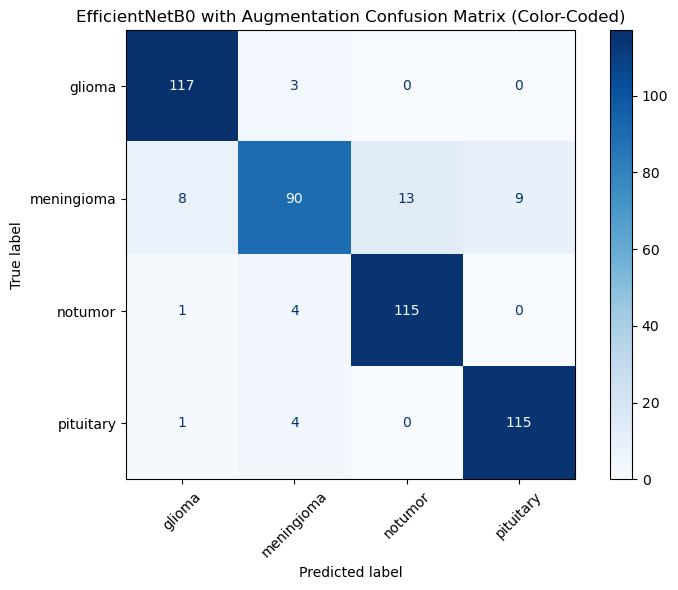

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(8, 6))  # Optional: set figure size
disp.plot(cmap='Blues', ax=ax, xticks_rotation=45)
ax.set_title('EfficientNetB0 with Augmentation Confusion Matrix (Color-Coded)')
plt.tight_layout()
plt.show()


## Evaluate the Model on the Test Set

In [17]:
# Reset the test generator and make predictions
preds = model.predict(test_generator)

# Convert the predicted probabilities to class labels
y_pred = np.argmax(preds, axis=1)

# True labels from the test generator
y_true = test_generator.classes



NameError: name 'test_generator' is not defined

## Visualise Sample Images from the Dataset

In [ ]:
import matplotlib.pyplot as plt
class_names = test_generator.class_indices
inv_class_names = {v: k for k, v in class_names.items()}

# Show first 9 images from test set
plt.figure(figsize=(10, 10))
for i in range(9):
    img, label = test_generator[i]
    plt.subplot(3, 3, i + 1)
    plt.imshow(img[0].astype('uint8'))
    plt.title(f"Label: {inv_class_names[np.argmax(label[0])]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

NameError: name 'test_generator' is not defined

## Visualise Misclassified Samples

In [ ]:
# Show first 9 misclassified examples
pred_labels = np.argmax(preds, axis=1)
true_labels = test_generator.classes
misclassified_idx = np.where(pred_labels != true_labels)[0]

plt.figure(figsize=(10, 10))
for i, idx in enumerate(misclassified_idx[:9]):
    img, _ = test_generator[idx]
    plt.subplot(3, 3, i + 1)
    plt.imshow(img[0].astype('uint8'))
    plt.title(f"True: {class_labels[true_labels[idx]]}, Pred: {class_labels[pred_labels[idx]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

NameError: name 'test_generator' is not defined